In [73]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import os
import scipy.stats as stats
import matplotlib.pyplot as plt

directory = os.getcwd()
filepath = os.path.join(directory, 'data/data1.xlsx')

dict = pd.read_excel(filepath, sheet_name=None)
for df in dict.values():
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

df_eur = dict["Eurotunnel"]
df_lor = dict["L'Oréal"]

df_eur['return(t)'] = df_eur['close'].pct_change()
df_lor['return(t)'] = df_lor['close'].pct_change()
df_eur['return(t-1)'] = df_eur['return(t)'].shift(1)
df_lor['return(t-1)'] = df_lor['return(t)'].shift(1)

In [74]:
def fit_distributions(data):
    distributions = {
        'norm': stats.norm,
        'lognorm': stats.lognorm,
        'cauchy': stats.cauchy,
        't': stats.t,
        'jf_skew_t': stats.jf_skew_t,
        'uniform': stats.uniform,
    }
    
    results = []
    for name, dist in distributions.items():
        # Fit distribution to data
        params = dist.fit(data)
        
        # Calculate goodness of fit
        log_likelihood = np.sum(dist.logpdf(data, *params))
        aic = 2 * len(params) - 2 * log_likelihood
        bic = len(params) * np.log(len(data)) - 2 * log_likelihood
        
        results.append({
            'Distribution': name,
            'AIC': aic,
            'BIC': bic,
            'Params': params
        })
    
    results_df = pd.DataFrame(results)
    return results_df.sort_values(by='AIC').reset_index(drop=True)

data = df_lor['return(t)'].dropna()
fit_results = fit_distributions(data)
fit_results

/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6617: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


,Distribution,AIC,BIC,Params
0,t,-1886.365854,-1874.398970,"(7.582224512496065, 0.0001636908617485299, 0.0..."
1,norm,-1873.571244,-1865.593321,"(0.00015478209832524552, 0.02301095888796299)"
2,lognorm,-1871.281875,-1859.314991,"(0.00652654627020747, -3.5232848912446384, 3.5..."
3,jf_skew_t,-1869.858008,-1853.902163,"(1.61107649808155, 1.3985860419745912, -0.0031..."
4,cauchy,-1782.385191,-1774.407268,"(0.00029673099517822264, 0.012443148413348317)"
5,uniform,-1303.798347,-1295.820424,"(-0.1111825192802055, 0.194204209631739)"


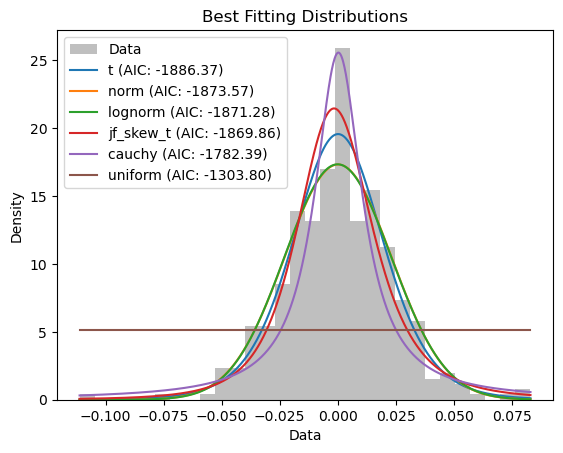

In [75]:
def plot_best_fit(data, fit_results, num_distributions=6):
    # Plot histogram of data
    plt.hist(data, bins=30, density=True, alpha=0.5, color='gray', label='Data')
    
    # Plot top `num_distributions` best-fitted PDFs
    for i in range(num_distributions):
        dist_name = fit_results['Distribution'].iloc[i]
        dist = getattr(stats, dist_name)
        params = fit_results['Params'].iloc[i]
        
        # Create a range of x values
        x = np.linspace(min(data), max(data), 1000)
        pdf = dist.pdf(x, *params)
        
        plt.plot(x, pdf, label=f'{dist_name} (AIC: {fit_results["AIC"].iloc[i]:.2f})')
    
    plt.legend()
    plt.xlabel('Data')
    plt.ylabel('Density')
    plt.title('Best Fitting Distributions')
    plt.show()

# Plot best fits
plot_best_fit(data, fit_results)

In [76]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import os

# Load data
directory = os.getcwd()
filepath = os.path.join(directory, 'data/data1.xlsx')
data_dict = pd.read_excel(filepath, sheet_name=None)

for df in data_dict.values():
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

df_eur = data_dict["Eurotunnel"]
df_lor = data_dict["L'Oréal"]

# Calculate returns
df_eur['return(t)'] = df_eur['close'].pct_change()
df_lor['return(t)'] = df_lor['close'].pct_change()
df_eur['return(t-1)'] = df_eur['return(t)'].shift(1)
df_lor['return(t-1)'] = df_lor['return(t)'].shift(1)

# Define function to fit distributions and use KS test
def fit_distributions_ks(data):
    distributions = {
        'norm': stats.norm,
        'lognorm': stats.lognorm,
        'cauchy': stats.cauchy,
        't': stats.t,
        'jf_skew_t': stats.jf_skew_t,
        'uniform': stats.uniform,
    }
    
    results = []
    for name, dist in distributions.items():
        # Fit distribution to data
        params = dist.fit(data)
        
        # Perform KS test
        D, p_value = stats.kstest(data, dist.cdf, args=params)
        
        results.append({
            'Distribution': name,
            'KS Statistic': D,
            'p-value': p_value,
            'Params': params
        })
    
    results_df = pd.DataFrame(results)
    return results_df.sort_values(by='KS Statistic').reset_index(drop=True)

# Run fit on the data
data = df_lor['return(t)'].dropna()
fit_results_ks = fit_distributions_ks(data)
fit_results_ks

/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6617: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


,Distribution,KS Statistic,p-value,Params
0,t,0.043161,4.349074e-01,"(7.582224512496065, 0.0001636908617485299, 0.0..."
1,norm,0.043682,4.197977e-01,"(0.00015478209832524552, 0.02301095888796299)"
2,lognorm,0.044166,4.060478e-01,"(0.00652654627020747, -3.5232848912446384, 3.5..."
3,jf_skew_t,0.057965,1.316540e-01,"(1.61107649808155, 1.3985860419745912, -0.0031..."
4,cauchy,0.068061,4.732867e-02,"(0.00029673099517822264, 0.012443148413348317)"
5,uniform,0.346287,3.010614e-43,"(-0.1111825192802055, 0.194204209631739)"


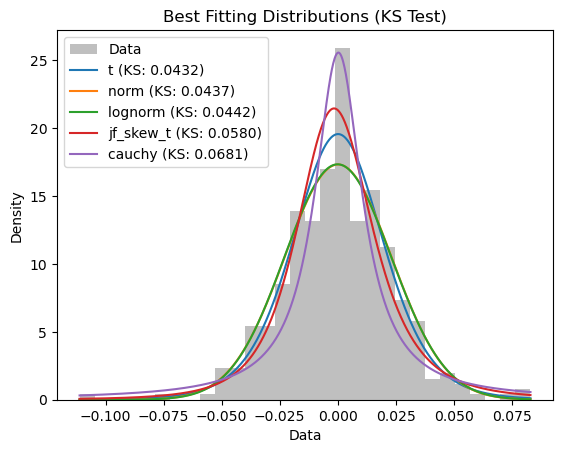

In [77]:

# Function to plot best fits
def plot_best_fit_ks(data, fit_results, num_distributions=5):
    # Plot histogram of data
    plt.hist(data, bins=30, density=True, alpha=0.5, color='gray', label='Data')
    
    # Plot top `num_distributions` best-fitted PDFs
    for i in range(num_distributions):
        dist_name = fit_results['Distribution'].iloc[i]
        dist = getattr(stats, dist_name)
        params = fit_results['Params'].iloc[i]
        
        # Create a range of x values
        x = np.linspace(min(data), max(data), 1000)
        pdf = dist.pdf(x, *params)
        
        plt.plot(x, pdf, label=f'{dist_name} (KS: {fit_results["KS Statistic"].iloc[i]:.4f})')
    
    plt.legend()
    plt.xlabel('Data')
    plt.ylabel('Density')
    plt.title('Best Fitting Distributions (KS Test)')
    plt.show()

# Plot best fits
plot_best_fit_ks(data, fit_results_ks)

In [78]:
data = df_eur['return(t)'].dropna()
fit_results = fit_distributions(data)
fit_results

/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6617: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


,Distribution,AIC,BIC,Params
0,jf_skew_t,-3728.532052,-3709.993518,"(1.295029632572808, 1.1167003752854492, -0.003..."
1,t,-3725.728490,-3711.824590,"(2.3214615286343996, -0.0012400571865934704, 0..."
2,cauchy,-3653.680362,-3644.411095,"(-0.0011661259680986408, 0.009294039719038815)"
3,lognorm,-3531.335037,-3517.431137,"(0.08320825634441287, -0.28525203856979553, 0...."
4,norm,-3499.561444,-3490.292177,"(0.0003481886438409607, 0.024212547435476094)"
5,uniform,-1924.552692,-1915.283425,"(-0.10465116279069764, 0.2816423132331758)"


In [79]:
fit_results_ks = fit_distributions_ks(data)
fit_results_ks

/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6617: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


,Distribution,KS Statistic,p-value,Params
0,jf_skew_t,0.140798,1.264329e-13,"(1.295029632572808, 1.1167003752854492, -0.003..."
1,t,0.143621,3.678319e-14,"(2.3214615286343996, -0.0012400571865934704, 0..."
2,cauchy,0.149455,2.649365e-15,"(-0.0011661259680986408, 0.009294039719038815)"
3,lognorm,0.159293,2.462307e-17,"(0.08320825634441287, -0.28525203856979553, 0...."
4,norm,0.175908,4.561860e-21,"(0.0003481886438409607, 0.024212547435476094)"
5,uniform,0.452863,4.735681e-143,"(-0.10465116279069764, 0.2816423132331758)"


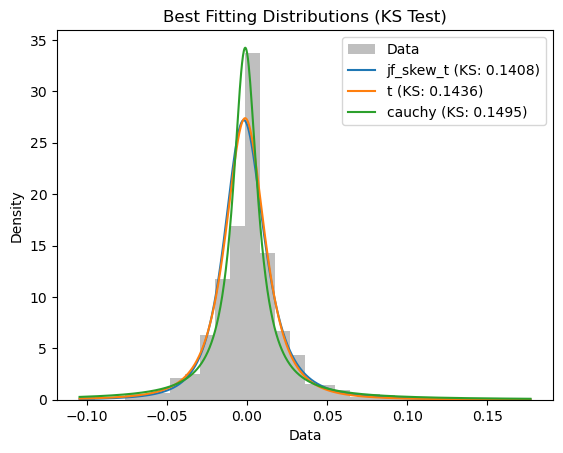

In [80]:
# Function to plot best fits
def plot_best_fit_ks(data, fit_results, num_distributions=3):
    # Plot histogram of data
    plt.hist(data, bins=30, density=True, alpha=0.5, color='gray', label='Data')
    
    # Plot top `num_distributions` best-fitted PDFs
    for i in range(num_distributions):
        dist_name = fit_results['Distribution'].iloc[i]
        dist = getattr(stats, dist_name)
        params = fit_results['Params'].iloc[i]
        
        # Create a range of x values
        x = np.linspace(min(data), max(data), 1000)
        pdf = dist.pdf(x, *params)
        
        plt.plot(x, pdf, label=f'{dist_name} (KS: {fit_results["KS Statistic"].iloc[i]:.4f})')
    
    plt.legend()
    plt.xlabel('Data')
    plt.ylabel('Density')
    plt.title('Best Fitting Distributions (KS Test)')
    plt.show()

# Plot best fits
plot_best_fit_ks(data, fit_results_ks)